<a name='1'></a>
## 1 - Packages

Begin by importing all the packages you'll need during this assignment. 

- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.
- `dnn_app_utils` provides the functions implemented in the "Building your Deep Neural Network: Step by Step" assignment to this notebook.
- `np.random.seed(1)` is used to keep all the random function calls consistent. It helps grade your work - so please don't change it! 

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

# 2 creation of some use ful function for models 

In [2]:
#activation functions 
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache



In [3]:
def relu(Z):
    A=np.maximum(0,Z)
    assert(A.shape == Z.shape)

    cache = Z 
    return A, cache

In [4]:
#back_propagation functions 
def sigmoid_backward(dA, cache):
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ


In [5]:
def relu_backward(dA,cache):
     Z = cache
     dZ = np.array(dA, copy=True)
     return dZ

In [6]:
#lod data function
def load_data():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    #here i am using cat vs not cat dataset
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes
#these function returns train_data_sets,test_data_sets,and classes

# 2.1 Initilizatiion of parameters 

In [7]:
def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(1)
    
    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1))
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    #here i am stroing all the elements in dictionry so that retreiving is easy
    return parameters     

In [8]:
def initialize_parameters_deep(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters
#it is same fuction as upper but  for L-layer deep network

# 2.2 forward proagation

In [9]:
def linear_forward(A, W, b):
    Z = np.dot(W,A) + b
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache=(A,W,b)
    return Z,cache


In [10]:

def linear_activation_forward(A_prev, W, b, activation):
    #forward prop for activaction fucntions 
     if activation == "sigmoid":
            Z, linear_cache = linear_forward(A_prev, W, b)
            A, activation_cache = sigmoid(Z)
     elif activation == "relu":
        
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)    
     cache = (linear_cache, activation_cache)

     return A, cache   

In [11]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters)//2  # number of layers in the neural network
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    return AL, caches


# 2.3 compute cost

In [12]:
def compute_cost(AL, Y):
    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost) 
    return cost

# 2.4 backward propagation

In [13]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    return dA_prev, dW, db

In [14]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db


In [30]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    return grads 
   
     


In [16]:
#update parameters
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

# 2.5 prediction function

In [17]:
def predict(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2 
    p = np.zeros((1,m))
    probas, caches = L_model_forward(X, parameters)
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p         



# 3. Model creation 

<h3> 3.1 data loading </h3>

In [18]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 0. It's a non-cat picture.


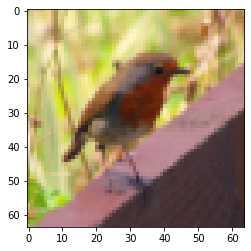

In [19]:
 #Example of a data
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [20]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


As usual, you reshape and standardize the images before feeding them to the network. The code is given in the cell below.

<img src="imvectorkiank.png" style="width:450px;height:300px;">
<caption><center><font color='purple'><b>Figure 1</b>: Image to vector conversion.</font></center></caption>

In [21]:
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T 
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


Now that you're familiar with the dataset, it's time to build a deep neural network to distinguish cat images from non-cat images!

You're going to build two different models:

- A 2-layer neural network
- An L-layer deep neural network

Then, you'll compare the performance of these models, and try out some different values for $L$. 

Let's look at the two architectures:

<img src="images/2layerNN_kiank.png" style="width:650px;height:400px;">
<caption><center><font color='purple'><b>Figure 2</b>: 2-layer neural network. <br> The model can be summarized as: INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT.</font></center></caption>

<u><b>Detailed Architecture of Figure 2</b></u>:
- The input is a (64,64,3) image which is flattened to a vector of size $(12288,1)$. 
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 12288)$.
- Then, add a bias term and take its relu to get the following vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- Repeat the same process.
- Multiply the resulting vector by $W^{[2]}$ and add the intercept (bias). 
- Finally, take the sigmoid of the result. If it's greater than 0.5, classify it as a cat.

In [22]:
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)
learning_rate = 0.0075

In [23]:
# GRADED FUNCTION: two_layer_model

### CONSTANTS DEFINING THE MODEL ####

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    #(≈ 1 line of code)
    parameters = initialize_parameters(n_x,n_h,n_y)
    # YOUR CODE STARTS HERE
    
    
    # YOUR CODE ENDS HERE
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        #(≈ 2 lines of code)
        A1, cache1 = linear_activation_forward(X,W1,b1,'relu')
        
        A2, cache2 = linear_activation_forward(A1,W2,b2,'sigmoid')
        # YOUR CODE STARTS HERE
        
        
        # YOUR CODE ENDS HERE
        
        # Compute cost
        #(≈ 1 line of code)
        cost = compute_cost(A2,Y)
        # YOUR CODE STARTS HERE
        
        
        # YOUR CODE ENDS HERE
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        #(≈ 2 lines of code)
        dA1, dW2, db2 = linear_activation_backward(dA2,cache2,'sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1,cache1,'relu')
        # YOUR CODE STARTS HERE
        
        
        # YOUR CODE ENDS HERE
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        #(approx. 1 line of code)
        parameters = update_parameters(parameters,grads,learning_rate)
        # YOUR CODE STARTS HERE
        
        
        # YOUR CODE ENDS HERE

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

    return parameters, costs

def plot_costs(costs, learning_rate=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

In [24]:
parameters, costs = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2, print_cost=False)

print("Cost after first iteration: " + str(costs[0]))

#two_layer_model_test(two_layer_model)

Cost after iteration 1: 0.6925287169677151
Cost after first iteration: 0.693049735659989


Cost after iteration 0: 0.693049735659989
Cost after iteration 100: 0.6464814962778067
Cost after iteration 200: 0.6326292445832459
Cost after iteration 300: 0.6018173143781715
Cost after iteration 400: 0.5629106542672492
Cost after iteration 500: 0.5343382798069629
Cost after iteration 600: 0.5252892115813032
Cost after iteration 700: 0.5223873318796263
Cost after iteration 800: 0.5215914864890695
Cost after iteration 900: 0.5229371916411151
Cost after iteration 1000: 0.5217628186992576
Cost after iteration 1100: 0.5169771136219967
Cost after iteration 1200: 0.5088004231908166
Cost after iteration 1300: 0.501710348529996
Cost after iteration 1400: 0.4976208632451348
Cost after iteration 1500: 0.49334675927790367
Cost after iteration 1600: 0.490032573313253
Cost after iteration 1700: 0.4864598735299734
Cost after iteration 1800: 0.48309668669630484
Cost after iteration 1900: 0.4799090261473232
Cost after iteration 2000: 0.47712059544146096
Cost after iteration 2100: 0.47477225131453116

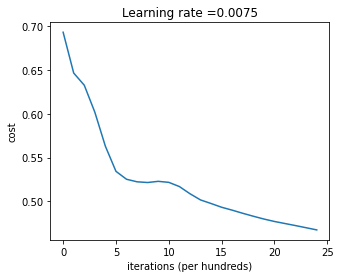

In [25]:
parameters, costs = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)
plot_costs(costs, learning_rate)

In [26]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.8133971291866027


In [27]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.8


# L-layer model

In [28]:
layers_dims = [12288, 20, 7, 5, 1]

In [46]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    np.random.seed(1)
    costs = []  
    parameters = initialize_parameters_deep(layers_dims)
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.676117
Cost after iteration 200: 0.665074
Cost after iteration 300: 0.657836
Cost after iteration 400: 0.653084
Cost after iteration 500: 0.649962
Cost after iteration 600: 0.647909
Cost after iteration 700: 0.646559
Cost after iteration 800: 0.645672
Cost after iteration 900: 0.645089
Cost after iteration 1000: 0.644706
Cost after iteration 1100: 0.644454
Cost after iteration 1200: 0.644289
Cost after iteration 1300: 0.644181
Cost after iteration 1400: 0.644109
Cost after iteration 1500: 0.644063
Cost after iteration 1600: 0.644032
Cost after iteration 1700: 0.644012
Cost after iteration 1800: 0.643999
Cost after iteration 1900: 0.643990
Cost after iteration 2000: 0.643985
Cost after iteration 2100: 0.643981
Cost after iteration 2200: 0.643978
Cost after iteration 2300: 0.643977
Cost after iteration 2400: 0.643976


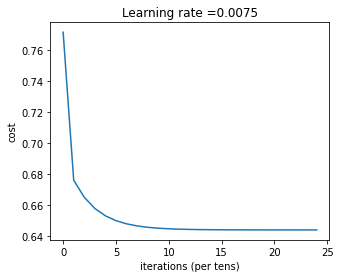

In [47]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

In [48]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.6555023923444976


In [45]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.3400000000000001
